In [1372]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import os
%run my_functions.ipynb

In [1386]:
def u0_gaussian(z, G_w = 0.5, G_a = 1, z_s = 100):
    return G_a*(np.exp(-((z - z_s)/G_w)**2) - np.exp(-((-z - z_s)/G_w)**2))

def u0_monopole(z, z_s, k_0, k):
    u_0 = 1/(k**2 + (z - z_s)**2)*np.exp(1j*k_0*np.sqrt(k**2 + (z - z_s)**2))
    return u_0

In [1404]:
def ifd_pe(f, topo, r, z, c, alpha, theta, rho, u0_func, z_s):

    """
    INPUTS
    f: the frequency in [Hz]
    r: the r values in [m]
    z: the z values in [m]
    c: an array of sound speed values in [m/s]
    alpha: an array of attenuation values in [dB/lambda]
    theta: the slope of the bottom in [rad]
    rho: an array of density at each point in the ocean [kg/m^3]
    u0_func: the function to use to generate u0
    z_s: depth of source
    
    """

    k = np.diff(r)[0]
    h = np.diff(z)[0]

    # define density profile
    rho_0 = rho[0,0]

    # define sound speed profile
    c_0 = 1500
    k_0   = 2*np.pi*f/c_0 # [1/m]

    # initialize field array
    u = np.zeros((np.size(r), np.size(z)))*(1 + 1j)

    # get initial field
    u[0,:] = u0_func(z, z_s, k_0, k)
    u[0,z_mesh > topo[0]] = 0

    # define refractive index
    n = (c_0/c)**2 + 1j*(c_0/c)**2 * alpha/27.287527

    # iterator over range
    nn = 0

    pbar = tqdm(total = np.size(r)-1, position = 0, leave = True)
    while nn < np.size(r)-1:

        # arrays used for accesssing off-diagonals
        rows = np.arange(np.size(z)-2)
        cols = np.arange(np.size(z)-2)

        # compute main diagonals
        # -----
        a = 1j/2*k_0*(n**2 - 1)
        b = 1j/(2*k_0) * np.ones_like(n)

        P = 1 / (1/b[:,1:-1] + (rho[:,1:-2]/rho[:,2:-1])*(1/b[:,1:-1]))
        Q = (a[:,1:-1]/b[:,1:-1] + (rho[:,1:-2]/rho[:,2:-1])*(a[:,1:-1]/b[:,1:-1]))
        
        X = h**2/(k*P) - (h**2/2*Q - (rho[:,1:-2]/rho[:,2:-1] + 1))
        Y = h**2/(k*P) + (h**2/2*Q - (rho[:,1:-2]/rho[:,2:-1] + 1))

        # get bottom conditions
        # ----- 
        theta = 0
        bottom_c = b[:,1:-1]*np.tan(theta) / (h - b[:,1:-1]*np.tan(theta)) # 1/h when theta = 0
        bottom_d = (np.tan(theta)*(a[:,1:-1] + 1j*k) - 2*b[:,1:-1]/h**2) / (1/h - b[:,1:-1]*np.tan(theta)/h**2) # -2b/h when theta = 0
        
        # populate tri-diagonal matrices
        A = np.diag(X[nn+1,:]) 
        A[rows[:-1],cols[1:]] = -rho[nn+1,1:-3]/rho[nn+1,2:-2]
        A[rows[1:], cols[:-1]] = -1*np.ones_like(rho[nn+1,2:-2])
        A[-1,-1] += bottom_d[nn+1,-1]
        A[-2,-1] += bottom_c[nn+1,-1]

        B = np.diag(Y[nn,:]) # M x M
        B[rows[:-1], cols[1:]] = rho[nn,1:-3]/rho[nn,2:-2]
        B[rows[1:], cols[:-1]] = np.ones_like(rho[nn,2:-2])
        B[-1,-1] -= bottom_d[nn,-1]
        B[-2,-1] -= bottom_c[nn,-1]

        b = B@u[nn,1:-1]
        b = b[:,np.newaxis]

        u[nn+1,1:-1] = scipy.sparse.linalg.spsolve(scipy.sparse.csr_matrix(A), scipy.sparse.csr_matrix(b))

        nn += 1
        pbar.update(1)

    pbar.close()
  
    return u


In [1406]:
f = 250 # [Hz]
r_max = 2500 # [m]
z_0 = 300 # [m]
z_s = 250 # [m]
z_lims = [0, 500] # [m]

[theta, alpha, rho, r_mesh, z_mesh, mesh_ssp, topo] = generate_physical_params(f, r_max, z_0, z_lims, roughness = 5, plot_flag = False)
u = ifd_pe(f, topo, r_mesh, z_mesh, mesh_ssp, alpha, np.transpose(np.tile(theta, (np.shape(alpha)[1],1))), rho, u0_monopole, z_s)

Mesh created with 518520 points.


/var/folders/mq/knq1z06s5zn3lq38hcwfcv900000gn/T/ipykernel_66244/1157088800.py:10: RuntimeWarning: invalid value encountered in divide
  theta = np.arctan(np.diff(topo)/np.diff(r_mesh)) # radians
100%|███████████████████████████████████████| 2979/2979 [01:40<00:00, 29.77it/s]


/var/folders/mq/knq1z06s5zn3lq38hcwfcv900000gn/T/ipykernel_66244/759599478.py:2: RuntimeWarning: divide by zero encountered in log10
  im = ax.pcolormesh(r_mesh, z_mesh, np.transpose(20*np.log10(np.abs(u/np.max(u[0,:])))), vmin = -60, shading='gouraud')


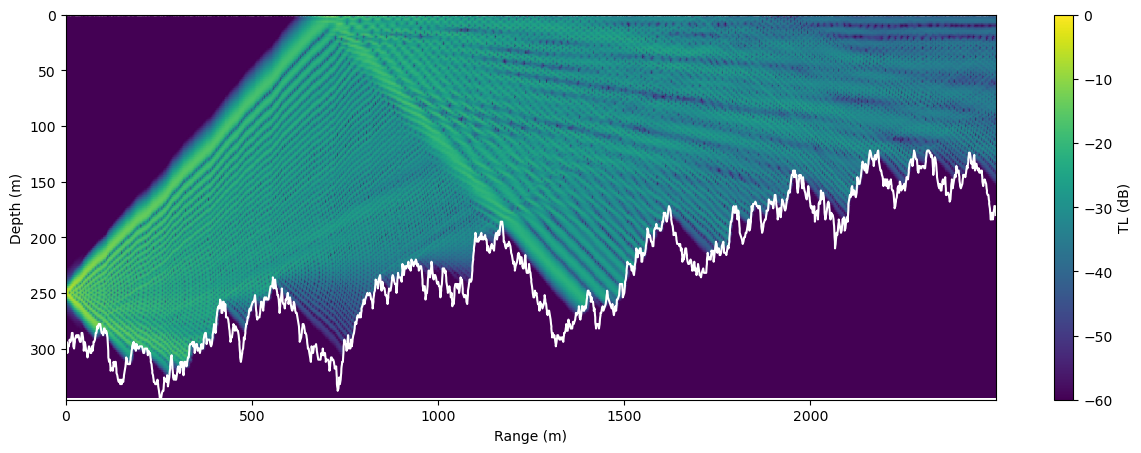

In [1414]:
fig, ax = plt.subplots(figsize = (15,5))
im = ax.pcolormesh(r_mesh, z_mesh, np.transpose(20*np.log10(np.abs(u/np.max(u[0,:])))), vmin = -60, shading='gouraud')
ax.plot(r_mesh, topo, 'w')
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Range (m)')
cbar = fig.colorbar(im, ax=ax, label='TL (dB)')

plt.savefig('Figures/250Hz_with_topography.png')